In [33]:
import os
import sys
sys.path.append("../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
from simulation.farm_env import FarmEnv
from stable_baselines3 import PPO

In [35]:
V1_MODEL_PATH = "../models/ppo_wheat_model.zip"
V2_MODEL_PATH = "../models/ppo_real_weather_final.zip"

In [36]:
eval_env = FarmEnv(simulation_days=90)
# To ensure a fair test, we can fix the random seed for weather generation
np.random.seed(42) # Use a fixed seed
eval_env.weather_data[:, 0] = np.random.rand(90) * 20 + 15  # Temp
eval_env.weather_data[:, 1] = np.random.rand(90) * 20      # Rain

# Load both agents
model_v1 = PPO.load(V1_MODEL_PATH, env=eval_env)
model_v2 = PPO.load(V2_MODEL_PATH, env=eval_env)

Soil Completed: Alluvial Starting Moisture: 50.0%
Crop Seed Ready: Wheat
Farm Environment Ready
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [37]:
def evaluate_agent(agent, environment):
    obs, _ = environment.reset()
    done = False
    daily_log = []
    
    while not done:
        action, _ = agent.predict(obs, deterministic=True)
        obs, reward, done, _, info = environment.step(action)
        
        daily_log.append({
            "day": environment.current_day,
            "soil_moisture": environment.soil.moisture_content,
            "crop_health": environment.crop.health,
            "yield_kg_per_ha": environment.crop.get_current_yield(),
            "irrigation_mm": environment.irrigation_map[int(action)],
        })
        
    return pd.DataFrame(daily_log)

Evaluating V1 Agent (Old Reward System)...
Soil Completed: Alluvial Starting Moisture: 50.0%
Crop Seed Ready: Wheat
Evaluating Final Agent (New Reward System)...
Soil Completed: Alluvial Starting Moisture: 50.0%
Crop Seed Ready: Wheat

--- PERFORMANCE COMPARISON ---

--- V1 Agent ---
Final Yield (kg/ha)       939.473776
Total Irrigation (mm)    1330.000000
Final Health (%)           18.789476
dtype: float64

--- V4 Agent ---
Final Yield (kg/ha)      382.053150
Total Irrigation (mm)    430.000000
Final Health (%)           7.641063
dtype: float64


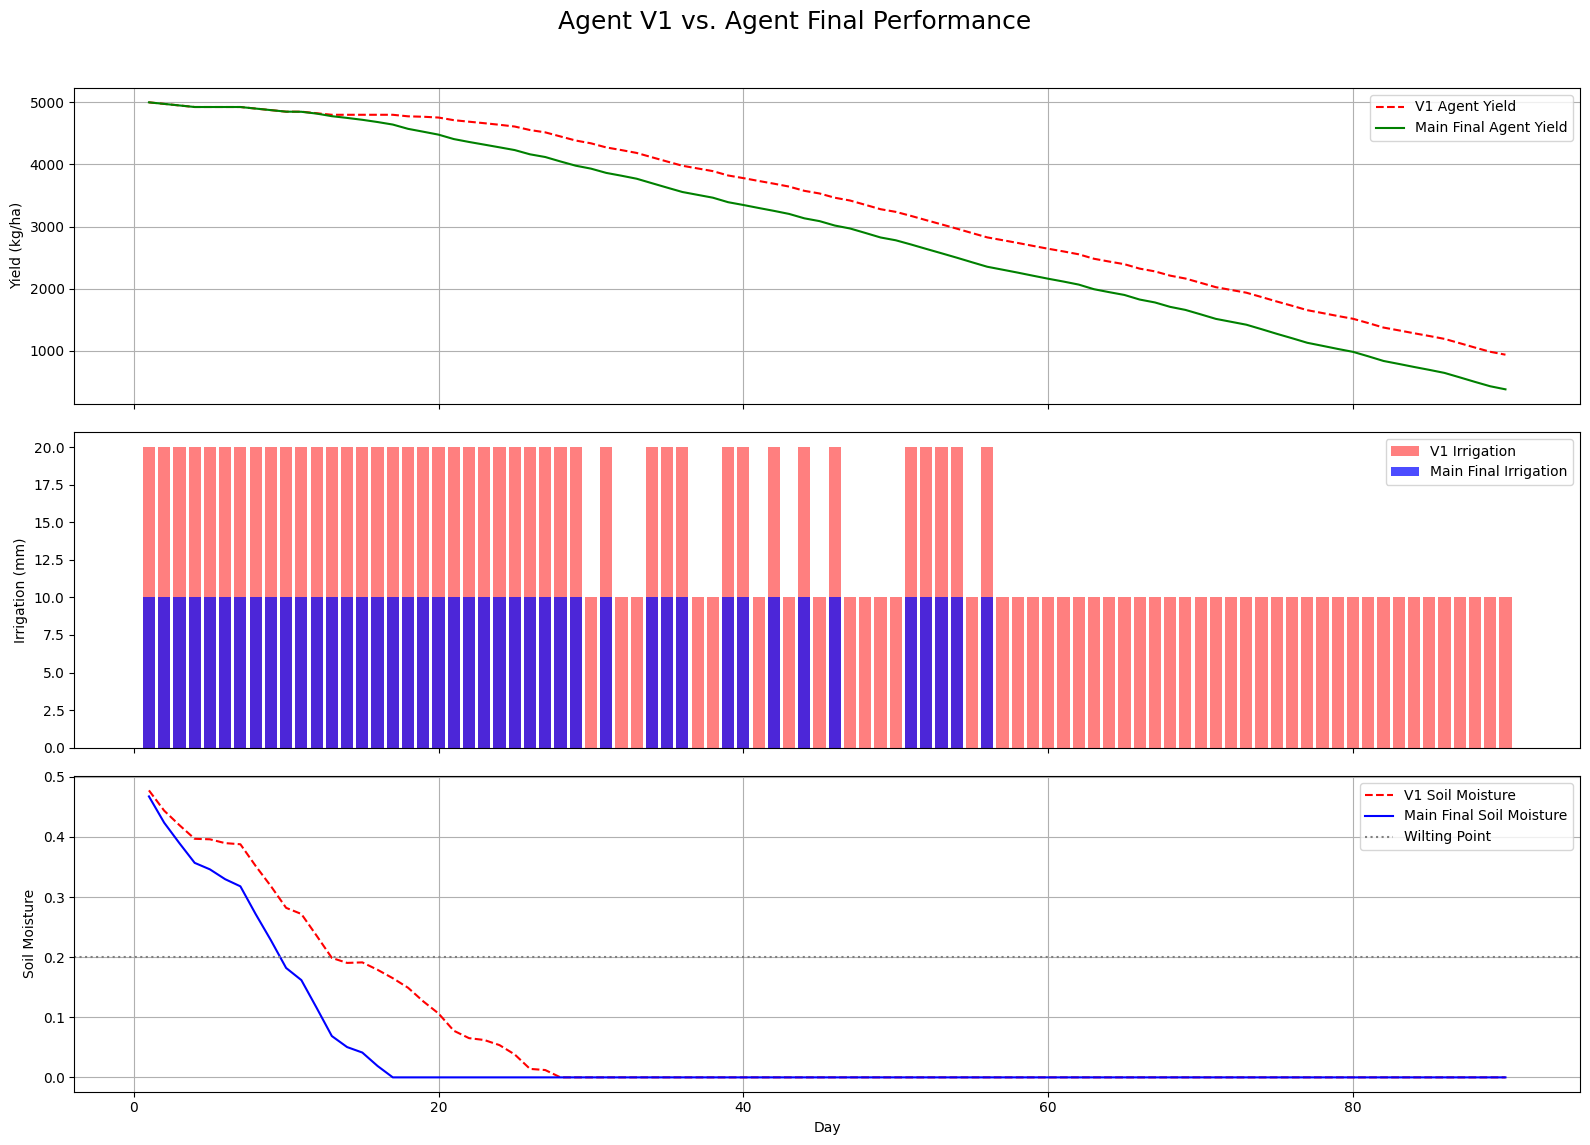

In [38]:

# --- Run Evaluations ---
print("Evaluating V1 Agent (Old Reward System)...")
v1_results_df = evaluate_agent(model_v1, eval_env)

print("Evaluating Final Agent (New Reward System)...")
v2_results_df = evaluate_agent(model_v2, eval_env)


# --- Print and Compare Summaries ---
v1_summary = {
    "Final Yield (kg/ha)": v1_results_df['yield_kg_per_ha'].iloc[-1],
    "Total Irrigation (mm)": v1_results_df['irrigation_mm'].sum(),
    "Final Health (%)": v1_results_df['crop_health'].iloc[-1]
}

v2_summary = {
    "Final Yield (kg/ha)": v2_results_df['yield_kg_per_ha'].iloc[-1],
    "Total Irrigation (mm)": v2_results_df['irrigation_mm'].sum(),
    "Final Health (%)": v2_results_df['crop_health'].iloc[-1]
}

print("\n--- PERFORMANCE COMPARISON ---")
print("\n--- V1 Agent ---")
print(pd.Series(v1_summary))
print("\n--- V4 Agent ---")
print(pd.Series(v2_summary))


# --- Visualize the Comparison ---
fig, axs = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
fig.suptitle("Agent V1 vs. Agent Final Performance", fontsize=18)

# Plot 1: Yield
axs[0].plot(v1_results_df['day'], v1_results_df['yield_kg_per_ha'], label='V1 Agent Yield', color='red', linestyle='--')
axs[0].plot(v2_results_df['day'], v2_results_df['yield_kg_per_ha'], label='Main Final Agent Yield', color='green')
axs[0].set_ylabel("Yield (kg/ha)")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Irrigation
axs[1].bar(v1_results_df['day'], v1_results_df['irrigation_mm'], label='V1 Irrigation', color='red', alpha=0.5)
axs[1].bar(v2_results_df['day'], v2_results_df['irrigation_mm'], label='Main Final Irrigation', color='blue', alpha=0.7)
axs[1].set_ylabel("Irrigation (mm)")
axs[1].legend()

# Plot 3: Soil Moisture
axs[2].plot(v1_results_df['day'], v1_results_df['soil_moisture'], label='V1 Soil Moisture', color='red', linestyle='--')
axs[2].plot(v2_results_df['day'], v2_results_df['soil_moisture'], label='Main Final Soil Moisture', color='blue')
axs[2].axhline(y=eval_env.soil.wilting_point, color='grey', linestyle=':', label='Wilting Point')
axs[2].set_ylabel("Soil Moisture")
axs[2].set_xlabel("Day")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()